## Review of obsids already observed with MS flag ignored for entire observation

In [103]:
from kadi import events
from Ska.engarchive import fetch
from Ska.Matplotlib import plot_cxctime

# Run from within a local repo of https://github.com/sot/aca_status_flags
# after ingesting the two observations of interest
import analysis_plots

%pylab inline

Populating the interactive namespace from numpy and matplotlib


I confirmed manually that these obsids have AOACIMSS set to 'DISA' for observation duration in telemetry.

In [104]:
obsids = [17198, 18718]

## Centroid residuals on these observations

2016-02-08 10:37:07,637: Slot 3: 45042 values: y_sig=0.25 y_std=0.28 z_sig=0.34 z_std=0.32
2016-02-08 10:37:07,643: Slot 4: 44872 values: y_sig=0.58 y_std=0.68 z_sig=0.67 z_std=0.73
2016-02-08 10:37:07,649: Slot 5: 44764 values: y_sig=0.34 y_std=0.34 z_sig=0.21 z_std=0.23
2016-02-08 10:37:07,654: Slot 6: 44962 values: y_sig=0.52 y_std=0.56 z_sig=0.59 z_std=0.54
2016-02-08 10:37:07,660: Slot 7: 44755 values: y_sig=0.39 y_std=0.41 z_sig=0.42 z_std=0.47


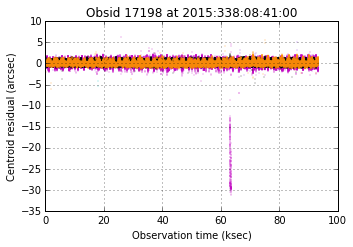

2016-02-08 10:37:08,095: Slot 3: 29232 values: y_sig=0.26 y_std=0.29 z_sig=0.37 z_std=0.35
2016-02-08 10:37:08,100: Slot 4: 28928 values: y_sig=0.61 y_std=0.67 z_sig=0.72 z_std=0.76
2016-02-08 10:37:08,104: Slot 5: 29026 values: y_sig=0.33 y_std=0.32 z_sig=0.21 z_std=0.23
2016-02-08 10:37:08,109: Slot 6: 28977 values: y_sig=0.56 y_std=0.61 z_sig=0.65 z_std=0.59
2016-02-08 10:37:08,114: Slot 7: 28950 values: y_sig=0.41 y_std=0.44 z_sig=0.42 z_std=0.46


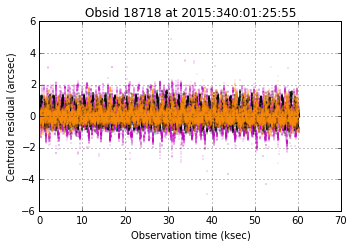

In [105]:
for obsid in obsids:
    figure()
    analysis_plots.plot_centroids(obsid, dp=None, ms=None)

## Attitude Errors

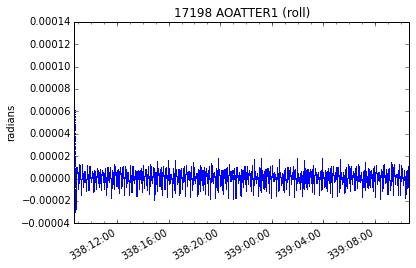

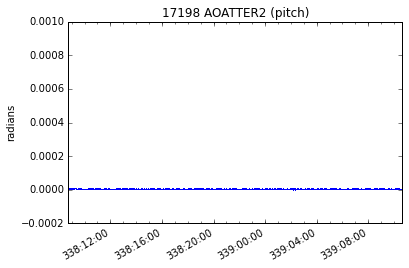

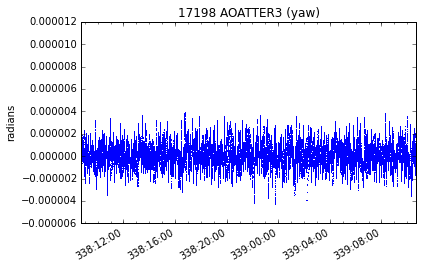

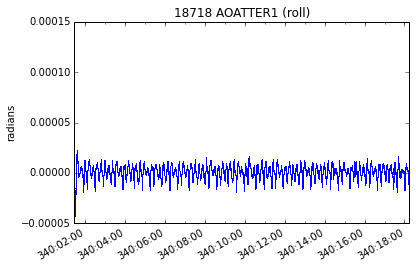

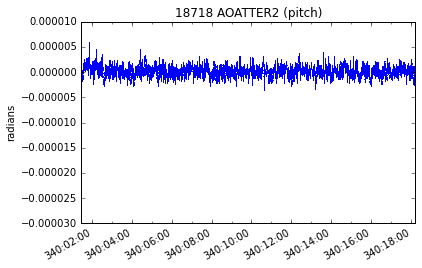

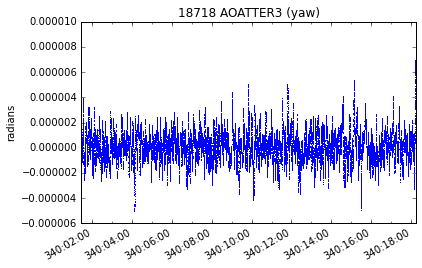

In [106]:
for obsid in obsids:
    manvr = events.manvrs.filter(obsid=obsid)[0]
    obs = events.obsids.filter(obsid=obsid)[0]
    att_msids = ['AOATTER1', 'AOATTER2', 'AOATTER3']
    axis_label = ['roll', 'pitch', 'yaw']
    obs_att_data = fetch.MSIDset(att_msids, manvr.kalman_start, obs.stop)
    for msid, label in zip(att_msids, axis_label):
        figure()
        plot_cxctime(obs_att_data[msid].times, obs_att_data[msid].vals, 'b,')
        title("{} {} ({})".format(obsid, msid, label))
        ylabel("radians")

## Check consistency of AOKALSTR with multiple star flag ignore

This is mostly a sanity check.

In [107]:
def get_combined_errs(slot_data, slots, flags):
    """
    For a given fetch multi-msid structure, a list of slots, and a list of flags,
    get the sum on any time slice of the stars that are either not tracked or have bad status
    """
    bad_sum = np.zeros(len(slot_data['AOACIMS3']))
    for slot in slots:
        nok = (slot_data["AOACFCT{}".format(slot)].vals != 'TRAK').astype(int)
        for msid in flags:
            nok = nok | (slot_data["{}{}".format(msid, slot)].vals != 'OK ').astype(int)
        bad_sum = bad_sum + nok
    return bad_sum

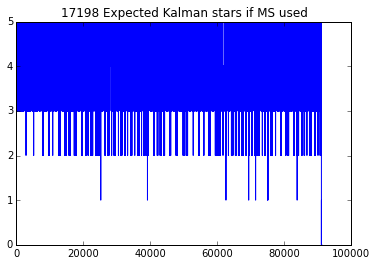

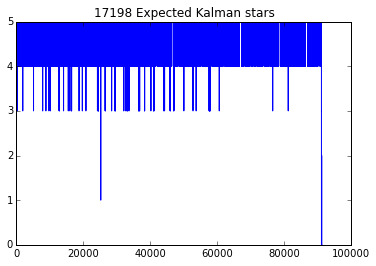

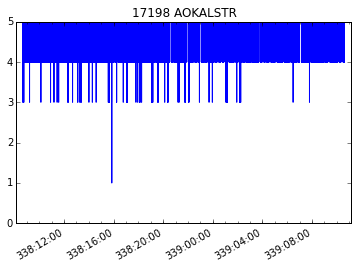

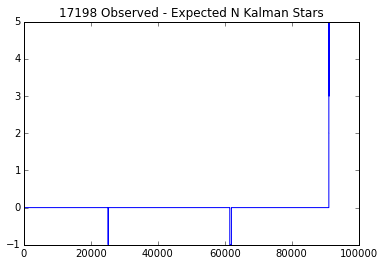

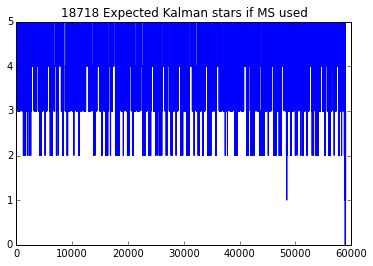

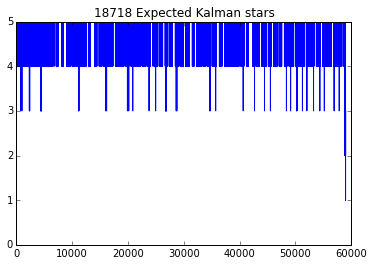

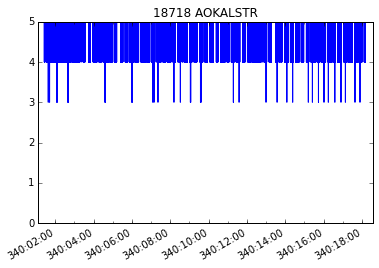

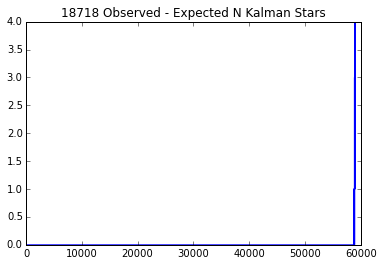

In [108]:
msids = ['AOACIMS', 'AOACISP', 'AOACIIR', 'AOACFCT', 'AOACYAN', 'AOACZAN', 'AOACMAG']
slots = [3, 4, 5, 6, 7]
slot_msids = ['{}{}'.format(msid, slot) for slot in slots for msid in msids]
for obsid in obsids:
    manvr = events.manvrs.filter(obsid=obsid)[0]
    obs = events.obsids.filter(obsid=obsid)[0]
    slot_data = fetch.MSIDset(slot_msids, manvr.kalman_start, obs.stop)
    # How many slots would be used in Kalman if respecting the MS flag
    bad_sum_with_ms = get_combined_errs(slot_data, slots, ['AOACIMS', 'AOACIIR', 'AOACISP'])
    # How many slots actually/expected in Kalman based only on flags and track status
    bad_sum_no_ms = get_combined_errs(slot_data, slots, ['AOACIIR', 'AOACISP'])
    figure()
    plot(5 - bad_sum_with_ms)
    title("{} {}".format(obsid, 'Expected Kalman stars if MS used'))
    ylim(0,5)
    figure()
    plot(5 - bad_sum_no_ms)
    title("{} {}".format(obsid, "Expected Kalman stars"))
    ylim(0,5)
    # This is largely consistent with what is actually seen in the KALSTR data
    kalstr_data = fetch.Msid('AOKALSTR', manvr.kalman_start, obs.stop)
    figure()
    kalstr_data.plot()
    ylim(ymin=0, ymax=5)
    title("{} {}".format(obsid, "AOKALSTR"))
    delta_kalstr = kalstr_data.vals.astype(int) - (5 - bad_sum_no_ms)
    figure()
    plot(delta_kalstr)
    title("{} {}".format(obsid, "Observed - Expected N Kalman Stars"))
